In [78]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import locale
from datetime import datetime

import statsmodels.api as sm
import itertools


from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

%matplotlib inline

## Exploration

In [3]:
raw = pd.read_csv('credit_defaults.csv')
raw.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [4]:
print('PAY: {}'.format(np.unique(raw[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].values)))
print('MARRIAGE: {}'.format(raw.MARRIAGE.unique()))
print('EDUCATION: {}'.format(raw.EDUCATION.unique()))

PAY: [-2 -1  0  1  2  3  4  5  6  7  8]
MARRIAGE: [1 2 3 0]
EDUCATION: [2 1 3 5 4 6 0]


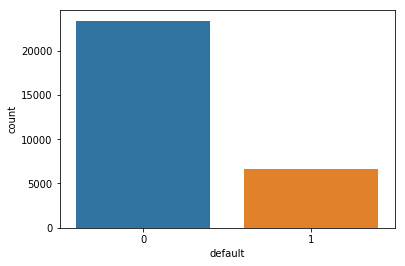

In [4]:
sns.countplot(x='default', data=raw)

In [7]:
columns = ['PAY_{}'.format(i) for i in range(1, 7)]
raw[columns].corr()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
PAY_1,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553
PAY_2,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501
PAY_3,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684
PAY_4,0.538841,0.662067,0.777359,1.000000,0.819835,0.716449
PAY_5,0.509426,0.622780,0.686775,0.819835,1.000000,0.816900
PAY_6,0.474553,0.575501,0.632684,0.716449,0.816900,1.000000


In [8]:
columns = ['BILL_AMT{}'.format(i) for i in range(1, 7)]
raw[columns].corr()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
BILL_AMT1,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650
BILL_AMT2,0.951484,1.000000,0.928326,0.892482,0.859778,0.831594
BILL_AMT3,0.892279,0.928326,1.000000,0.923969,0.883910,0.853320
BILL_AMT4,0.860272,0.892482,0.923969,1.000000,0.940134,0.900941
BILL_AMT5,0.829779,0.859778,0.883910,0.940134,1.000000,0.946197
BILL_AMT6,0.802650,0.831594,0.853320,0.900941,0.946197,1.000000


In [9]:
columns = ['PAY_AMT{}'.format(i) for i in range(1, 7)]
raw[columns].corr()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
PAY_AMT1,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735
PAY_AMT2,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634
PAY_AMT3,0.252191,0.244770,1.000000,0.216325,0.159214,0.162740
PAY_AMT4,0.199558,0.180107,0.216325,1.000000,0.151830,0.157834
PAY_AMT5,0.148459,0.180908,0.159214,0.151830,1.000000,0.154896
PAY_AMT6,0.185735,0.157634,0.162740,0.157834,0.154896,1.000000


In [10]:
columns = ['PAY_AMT{}'.format(i) for i in range(1, 7)]
columns.extend(['BILL_AMT{}'.format(i) for i in range(1, 7)])
raw[columns].corr()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
PAY_AMT1,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735,0.140277,0.280365,0.244335,0.233012,0.217031,0.199965
PAY_AMT2,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634,0.099355,0.100851,0.316936,0.207564,0.181246,0.172663
PAY_AMT3,0.252191,0.244770,1.000000,0.216325,0.159214,0.162740,0.156887,0.150718,0.130011,0.300023,0.252305,0.233770
PAY_AMT4,0.199558,0.180107,0.216325,1.000000,0.151830,0.157834,0.158303,0.147398,0.143405,0.130191,0.293118,0.250237
PAY_AMT5,0.148459,0.180908,0.159214,0.151830,1.000000,0.154896,0.167026,0.157957,0.179712,0.160433,0.141574,0.307729
PAY_AMT6,0.185735,0.157634,0.162740,0.157834,0.154896,1.000000,0.179341,0.174256,0.182326,0.177637,0.164184,0.115494
BILL_AMT1,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650
BILL_AMT2,0.280365,0.100851,0.150718,0.147398,0.157957,0.174256,0.951484,1.000000,0.928326,0.892482,0.859778,0.831594
BILL_AMT3,0.244335,0.316936,0.130011,0.143405,0.179712,0.182326,0.892279,0.928326,1.000000,0.923969,0.883910,0.853320
BILL_AMT4,0.233012,0.207564,0.300023,0.130191,0.160433,0.177637,0.860272,0.892482,0.923969,1.000000,0.940134,0.900941


In [120]:
def cplot(column):
    sns.countplot(x=column, hue='default', data=raw)
    for v in sorted(raw[column].unique()):
        f = raw[raw[column] == v]
        total = len(f)
        defaulted = len(f[f.default == 1])
        print('{}: {:.2f}%'.format(v, defaulted/total))

1: 0.24%
2: 0.21%


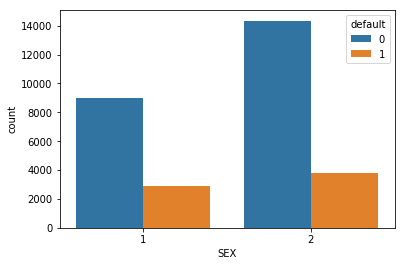

In [47]:
cplot('SEX')

0: 0.00%
1: 0.19%
2: 0.24%
3: 0.25%
4: 0.06%
5: 0.06%
6: 0.16%


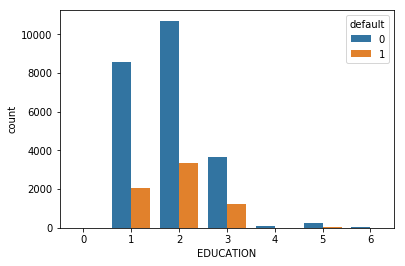

In [46]:
cplot('EDUCATION')

0: 0.09%
1: 0.23%
2: 0.21%
3: 0.26%


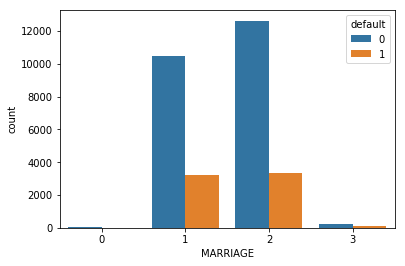

In [45]:
cplot('MARRIAGE')

-2: 0.13%
-1: 0.17%
0: 0.13%
1: 0.34%
2: 0.69%
3: 0.76%
4: 0.68%
5: 0.50%
6: 0.55%
7: 0.78%
8: 0.58%


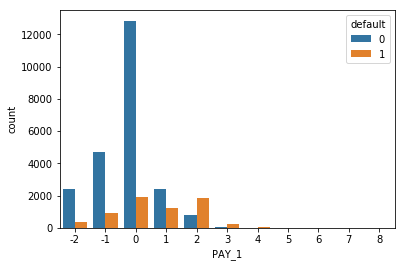

In [121]:
cplot('PAY_1')

## Cleaning

In [84]:
raw_data = raw.copy()

In [88]:
raw_data = raw_data.drop('ID', axis=1)

In [135]:
columns = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

raw_data[columns] = raw_data[columns].apply(lambda x: (x-np.mean(x))/np.std(x))

columns = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
raw_data[columns] = raw_data[columns].apply(lambda x: x+2)

X = raw_data.drop('default', axis=1)
y = raw_data.default

categorical_features_indexes = [1, 2, 3, 5, 6, 7, 8, 9, 10]
enc = OneHotEncoder(categorical_features=categorical_features_indexes)
X = enc.fit_transform(X)

## Feature Engineering

In [137]:
fe_data = raw_data.copy()

def total(row):
    pay_columns = ['PAY_AMT{}'.format(i) for i in range(1, 7)]
    bill_columns = ['BILL_AMT{}'.format(i) for i in range(1, 7)]
    pay_total = row[pay_columns].sum()
    bill_total = row[bill_columns].sum()
    return bill_total - pay_total
    
fe_data['total'] = fe_data.apply(lambda row: total(row), axis=1)

In [138]:
fe_data = fe_data[fe_data.total > -2000000]
fe_data = fe_data[fe_data.total < 4000000]

In [139]:
fe_data['ratio'] = fe_data.apply(lambda row: row.total / row.LIMIT_BAL, axis=1)

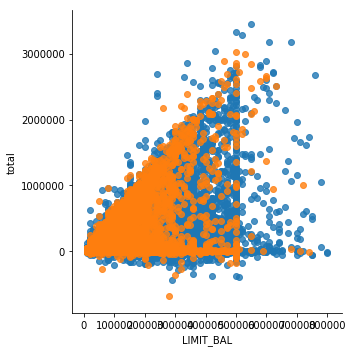

In [133]:
sns.lmplot(x='LIMIT_BAL', y='total', data=fe_data, fit_reg=False, hue='default', legend=False)

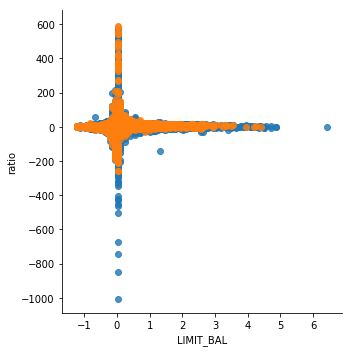

In [141]:
sns.lmplot(x='LIMIT_BAL', y='ratio', data=fe_data, fit_reg=False, hue='default', legend=False)

In [148]:
drop_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                'default'
               ]

fe_X = fe_data.drop(drop_columns, axis=1)
fe_y = fe_data.default

categorical_features_indexes = [1, 2, 3, 5, 6, 7, 8, 9, 10]
enc = OneHotEncoder(categorical_features=categorical_features_indexes)
fe_X = enc.fit_transform(fe_X)

## Split Data

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
fe_X_train, fe_X_test, fe_y_train, fe_y_test = train_test_split(fe_X, fe_y, test_size=0.3)

def test(clf, is_fe=False):
    Xt = fe_X_test if is_fe else X_test
    yt = fe_y_test if is_fe else y_test
    predicted = clf.predict(Xt)
    print("Test auc_roc: {}".format(roc_auc_score(y_score=predicted, y_true=yt)))

## Baseline (Logistic Regression)

In [158]:
def logistic_regression(X, y):
    C_values = [0.001, 0.01, 0.05, 0.1, 1., 10., 100.]
    clf = LogisticRegressionCV(
        Cs=C_values,
        scoring='roc_auc',
        cv=5,
        max_iter=10000,
        solver='liblinear',
        penalty='l1',
    )

    clf.fit(X, y)
    return clf

In [160]:
clf = logistic_regression(X_train, y_train)
print('Raw Data')
print('Max train auc_roc: {}'.format(clf.scores_[1].max()))
test(clf)

clf = logistic_regression(fe_X_train, fe_y_train)
print('\nFE Data')
print('Max train auc_roc: {}'.format(clf.scores_[1].max()))
test(clf, True)

Raw Data
Max train auc_roc: 0.7737350951656603
Test auc_roc: 0.6486734514827163

FE Data
Max train auc_roc: 0.7696404611521119
Test auc_roc: 0.6554824360867856


## Adaboost

In [161]:
def adaboost(X, y):
    adb_clf = AdaBoostClassifier(n_estimators=100)
    scores = cross_val_score(adb_clf, X, y, scoring='roc_auc', cv=5)
    print('Max train auc_roc: {}'.format(scores.mean()))

    adb_clf.fit(X, y)
    return adb_clf

In [162]:
print('Raw Data')
adb_clf = adaboost(X_train, y_train)
test(adb_clf)

print('\nFE Data')
adb_clf = adaboost(fe_X_train, fe_y_train)
test(adb_clf, True)

Raw Data
Max train auc_roc: 0.7580313913537167
Test auc_roc: 0.6483576065976487

FE Data
Max train auc_roc: 0.7701348319801327
Test auc_roc: 0.6501572782425296


## Random Forest

In [166]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)
test(rf_clf)

Test auc_roc: 0.6279154237585541


In [167]:
fe_rf_clf = RandomForestClassifier(n_estimators=100)
fe_rf_clf.fit(fe_X_train, fe_y_train)
test(fe_rf_clf, True)

Test auc_roc: 0.6500409146895643


In [70]:
n_estimators = range(10, 100, 20)
max_features = ['auto', 'sqrt']
max_depth = list(range(10, 100, 20))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

In [71]:
rf_random = RandomizedSearchCV(
    estimator=rf_clf, 
    param_distributions =random_grid, 
    n_iter=100, 
    cv=5,
    n_jobs = -1
)

In [72]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': range(10, 100, 20), 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 30, 50, 70, 90, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [73]:
rf_random.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 90}

In [74]:
rf_clf = RandomForestClassifier(**rf_random.best_params_)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [76]:
test(rf_clf)

auc_roc: 0.6533898812711124


In [79]:
param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [80, 90, 100]
}

rf_grid = GridSearchCV(
    estimator=rf_clf, 
    param_grid=param_grid,  
    cv=5,
    n_jobs = -1
)

In [80]:
rf_grid.fit(X_train, y_train)
rf_grid.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 100}

In [83]:
rf_clf = RandomForestClassifier(**rf_grid.best_params_)
rf_clf.fit(X_train, y_train)
test(rf_clf)

auc_roc: 0.6533764491694787
